<a href="https://colab.research.google.com/github/bgolshaei/Data_Science/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import pylab as pl
from pylab import *
import pandas as pd
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import cv2 as cv
import torch.utils.data as data_utils
import torch


# M3 Project
In first step, load the data and attach the position of pedestrian over the time to find out their trace.
## Data loading and preprocessing

In [3]:
from google.colab import files
uploaded = files.upload()

# To store dataset in a Pandas Dataframe
import io
df = pd.read_excel(io.BytesIO(uploaded['pixel_pos.xlsx']))
df

Saving pixel_pos.xlsx to pixel_pos.xlsx


,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,11,11.1,11.2,11.3,11.4,11.5,11.6,11.7,11.8,11.9,21,21.1,21.2,21.3,21.4,21.5,31,31.1,31.2,31.3,31.4,31.5,41,41.1,41.2,41.3,41.4,41.5,51,51.1,...,17971.1,17971.2,17971.3,17971.4,17971.5,17981,17981.1,17981.2,17981.3,17991,17991.1,17991.2,17991.3,18001,18001.1,18001.2,18011,18011.1,18011.2,18011.3,18021,18021.1,18021.2,18021.3,18031,18031.1,18031.2,18031.3,18041,18041.1,18041.2,18041.3,18051,18051.1,18051.2,18051.3,18061,18061.1,18061.2,18061.3
0,1.000000,2.000000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,9.000000,10.000000,1.000000,2.000000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,9.000000,10.000000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,3.000000,4.000000,...,415.000000,416.000000,417.000000,418.000000,419.00000,416.000000,417.000000,418.000000,419.00000,416.000000,417.000000,418.000000,419.00000,416.000000,417.00000,419.00000,416.00000,417.000000,419.00000,420.00000,416.000000,417.000000,419.000000,420.00000,416.000000,417.00000,419.000000,420.00000,416.000000,417.000000,419.000000,420.00000,416.000000,417.00000,419.000000,420.00000,416.000000,417.000000,419.00000,420.00000
1,0.000537,-0.058169,0.057966,0.089990,-0.19839,-0.20743,-0.25568,-0.18920,-0.015058,-0.099742,-0.008186,-0.055556,0.033936,0.091405,-0.19839,-0.20743,-0.25485,-0.18920,-0.013632,-0.099664,0.006626,0.089075,-0.19839,-0.20743,-0.25435,-0.18920,-0.019004,0.089006,-0.19839,-0.20743,-0.25070,-0.18920,-0.038338,0.088161,-0.19839,-0.20743,-0.25379,-0.18920,-0.065713,0.081802,...,-0.012193,-0.001213,0.096278,0.169740,0.12924,-0.003432,0.085950,0.171790,0.12923,-0.008060,0.081550,0.169630,0.12921,-0.007582,0.07842,0.13039,-0.00842,0.072937,0.12687,0.14095,-0.011595,0.074639,0.126930,0.14191,-0.011192,0.07748,0.126990,0.14649,-0.015692,0.076763,0.125920,0.14752,-0.016237,0.08181,0.130800,0.14847,-0.017156,0.086995,0.13086,0.14831
2,-0.184570,-0.268610,-0.104790,0.036724,0.26015,0.28619,0.35023,0.14792,-0.375330,-0.461820,-0.229380,-0.312070,-0.073139,0.085140,0.26015,0.28619,0.36388,0.14792,-0.417130,-0.460460,-0.030256,0.131390,0.26015,0.28619,0.37207,0.14792,0.002037,0.174680,0.26015,0.28619,0.38798,0.14792,0.037810,0.225920,0.26015,0.28619,0.42569,0.14792,0.068049,0.264910,...,-0.368770,-0.014703,-0.025790,0.008712,-0.30743,-0.054509,-0.060171,0.047385,-0.26277,-0.092789,-0.096616,0.073598,-0.21814,-0.128960,-0.13194,-0.17366,-0.16637,-0.165780,-0.12746,-0.37913,-0.200940,-0.201650,-0.081621,-0.33849,-0.238530,-0.23893,-0.035823,-0.29685,-0.274440,-0.274610,0.011378,-0.25501,-0.306650,-0.31603,0.057797,-0.21453,-0.345600,-0.354760,0.10345,-0.17268


In [4]:
df.T.groupby(0).get_group(387)

,0,1,2
16441.10,387.0,-0.041272,-0.440050
16451.10,387.0,-0.040914,-0.388690
16461.10,387.0,-0.048025,-0.335550
16471.10,387.0,-0.046330,-0.282980
16481.10,387.0,-0.049970,-0.235460
16491.9,387.0,-0.054718,-0.185130
16501.9,387.0,-0.049322,-0.134380
16511.9,387.0,-0.048961,-0.083250
16521.8,387.0,-0.043581,-0.032721
16531.8,387.0,-0.040869,0.015309


# Pre steps
In the data sets, the trajectory of the pedstraines are dispress over the frames therefore, attaching trajectories of all pedestrians all a nourish zero position to our final data sets.Therefore, To test the model and train it we start with simplest case. We choose the longest trajectory and we will try to predict its next steps.

In [5]:


sampl11=df.T.groupby(0).get_group(1)

for i in df.T.groupby(0).groups.keys():
  sampl11=pd.concat([sampl11,df.T.groupby(0).get_group(i).drop([0], axis=1)], axis=1,ignore_index=False)

data_clean=sampl11.fillna(0)
data_clean.loc[:, (data_clean==0).mean() < 6500]


,0,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,...,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2
1,1.0,0.000537,-0.18457,0.000537,-0.18457,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
11,1.0,-0.008186,-0.22938,-0.008186,-0.22938,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
1.1,0.0,0.000000,0.00000,0.000000,0.00000,-0.058169,-0.26861,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
11.1,0.0,0.000000,0.00000,0.000000,0.00000,-0.055556,-0.31207,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
1.2,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.057966,-0.10479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18021.3,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14191,-0.33849
18031.3,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14649,-0.29685
18041.3,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14752,-0.25501
18051.3,0.0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14847,-0.21453


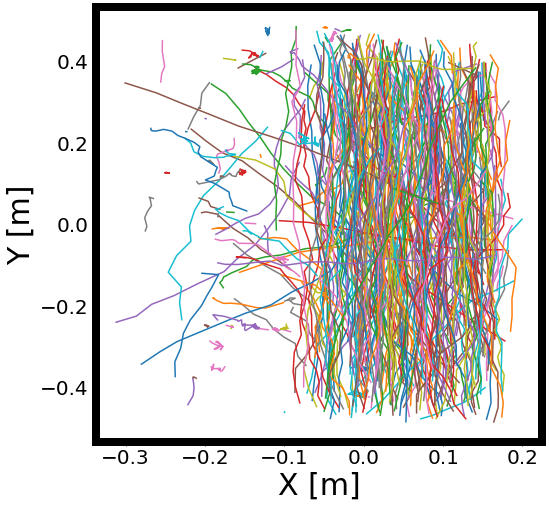

In [7]:
 for i in df.T.groupby(0).groups.keys():
   plt.plot(df.T.groupby(0).get_group(i)[1],df.T.groupby(0).get_group(i)[2])
plt.xlabel('X [m]',fontsize=30)
plt.ylabel('Y [m]',fontsize=30)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams.update({'font.size': 20})

Text(0.5, 0, 'X [m]')

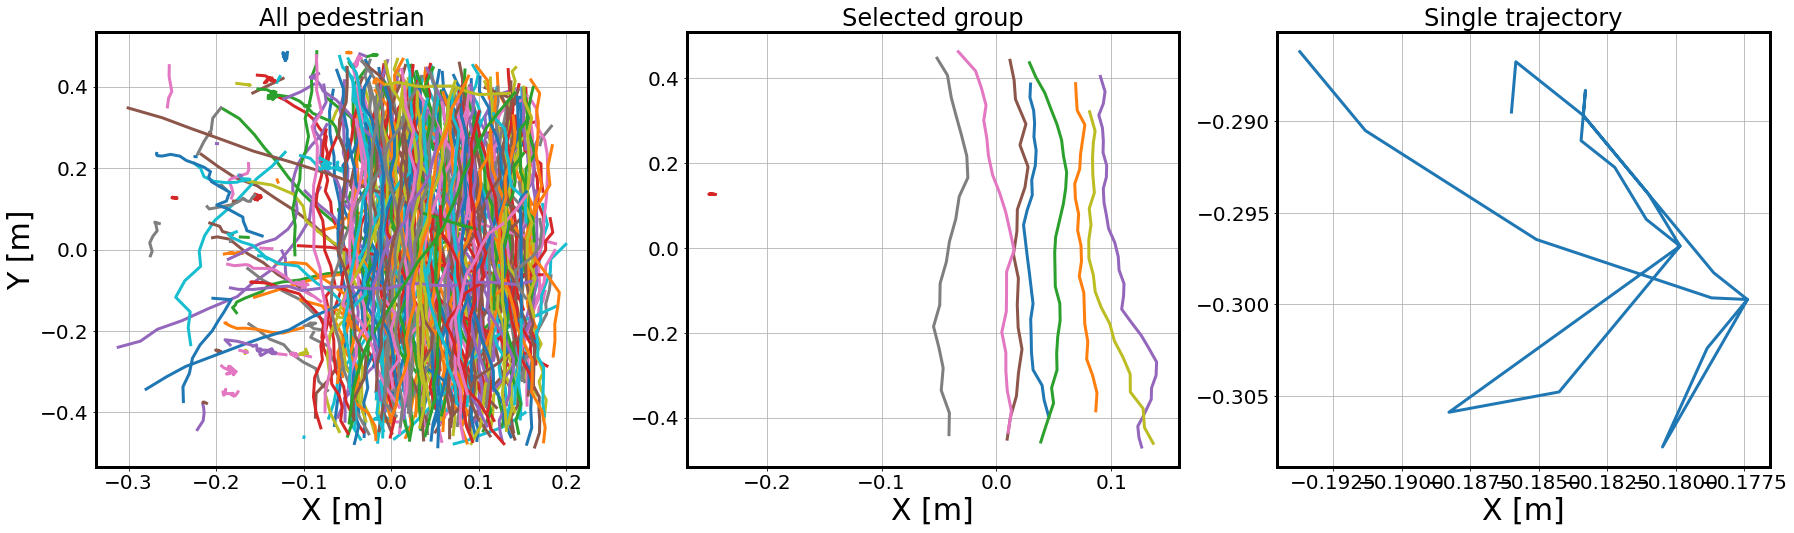

In [21]:
selected_data=[376,377,380,381,382,384,385,387,388]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))
ax = axs[0]

for i in df.T.groupby(0).groups.keys():
   ax.plot(df.T.groupby(0).get_group(i)[1],df.T.groupby(0).get_group(i)[2],lw=3)
ax.grid()
ax.set_title("All pedestrian")
ax.set_xlabel("X [m]",fontsize=30)
ax.set_ylabel("Y [m]",fontsize=30)
ax = axs[1]
for i in selected_data:
   ax.plot(df.T.groupby(0).get_group(i)[1],df.T.groupby(0).get_group(i)[2],label=str(i),lw=3)
ax.grid()
ax.set_title("Selected group")
ax.set_xlabel("X [m]",fontsize=30)

ax = axs[2]
ax.plot(df.T.groupby(0).get_group(38)[1],df.T.groupby(0).get_group(38)[2],lw=3)
ax.grid()
ax.set_title("Single trajectory")
ax.set_xlabel("X [m]",fontsize=30)


# First Approach the longest trajectory

In [5]:
#distribution of the Pedstrains trajectories length
df.T.groupby(0).size().sort_values()

0
314.0      1
1.0        2
2.0        2
178.0      2
202.0      2
        ... 
371.0     67
369.0     67
356.0     77
361.0     87
38.0     100
Length: 390, dtype: int64

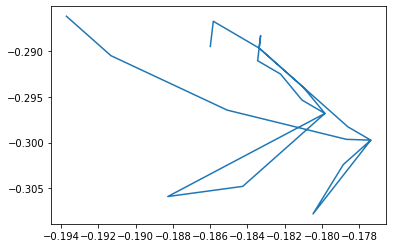

In [6]:
#The longest trajectory

plt.plot(df.T.groupby(0).get_group(38)[1],df.T.groupby(0).get_group(38)[2])

In [7]:
data_clean=sampl11.fillna(0)
drop_data=data_clean.loc[:, (data_clean==0).mean() < 0.997]

In [34]:

x_train = df.T.groupby(0).get_group(38).iloc[:50, :][2].to_numpy()
x_test = df.T.groupby(0).get_group(38).iloc[50:100,:][2]
y_train = df.T.groupby(0).get_group(38).iloc[:50, :][1].to_numpy()
y_test = df.T.groupby(0).get_group(38).iloc[50:100,:][1]

# Training of the netwrok

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:


###### for prediction ############
series_t = torch.tensor(np.arange(len(x_train)))

scale_t=torch.ones(20,len(x_train))
time_2d=torch.mul(series_t, scale_t)
series_t = torch.unsqueeze(series_t, dim=1)
series_t = torch.unsqueeze(series_t, dim=1)


In [142]:
split_time = 1
window_size = 15
batch_size = 4
input_dim = 1
hidden_dim = 40
out_dim = 1
num_layers = 40
num_dir = 2
num_epochs = 100
learning_rate = 0.005
rnn_module = "lstm"  #lsdm  

In [41]:
def Windowed_Dataset(series, window_size, stride, batch_size):
    """
    params:
        series: time series data
        window_size: K
        stride: stride between windows
        batch_size: batch size for training
    return:
        ds_loader: wrap windowed data into pytorch dataloader
    """
    f_s = window_size + 1
    l = len(series)
    ds = torch.from_numpy(series)
    ds = torch.unsqueeze(ds, dim=1)
    ds = [ds[i:i+f_s] for i in range(0, l, stride) if i <= l-f_s]
    #print(ds)
    ds_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=1)
    return ds_loader
train_loader= Windowed_Dataset(x_train, window_size=window_size, stride=1, batch_size=batch_size)
test_loader= Windowed_Dataset(x_test.to_numpy(), window_size=window_size, stride=1, batch_size=batch_size)

In [40]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.out_dim = out_dim 
        self.bs = batch_size
        self.nd = num_dir
        
        if self.nd == 2:
            bidir = True
        else:
            bidir = False
        if rnn_module == "srnn":
            self.rnnmodule = nn.RNN(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidir)
        elif rnn_module == "lstm":
            self.rnnmodule = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidir)
        self.linear = nn.Linear(self.hidden_dim*self.nd, self.out_dim)
        
    
    def forward(self, x):
#         h0 = torch.zeros(self.num_layers, self.bs, self.hidden_dim).to(device)
        #print("hi1")
        #hidden = self._init_hidden(batch_size)

        out, _ = self.rnnmodule(x)
        
        out = self.linear(out[-1])
        
        out = out*500
        return out

In [145]:
model = RNN(input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module)
model = model.to(device)
criterion = nn.SmoothL1Loss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

RNN(
  (rnnmodule): LSTM(1, 40, num_layers=40, bidirectional=True)
  (linear): Linear(in_features=80, out_features=1, bias=True)
)


In [146]:
best_loss = 1e+100
test_Loss_lstm_15=torch.zeros(num_epochs)
train_Loss_lstm_15=torch.zeros(num_epochs)
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    running_test_loss = 0
    for batch_index, item in enumerate(train_loader):
        
        inputs = item[0:batch_size,0:-1]
        #print(inputs.size())
        #print(inputs)
        inputs = torch.transpose(inputs, 0, 1)
        inputs = inputs.float()
        inputs = inputs.to(device)
        #print(inputs)
        target = item[0:batch_size,-1:].squeeze(dim=1)
        target = target.float()
        target = target.to(device)

        optimizer.zero_grad()
        #print(inputs.size())
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()  
    with torch.no_grad():
        for batch_index, item in enumerate(test_loader):
            inputs_test = item[0:batch_size,0:-1]
            inputs_test = torch.transpose(inputs_test, 0, 1)
            inputs_test = inputs_test.float()
            inputs_test = inputs_test.to(device)
            target_test = item[0:batch_size,-1:].squeeze(dim=1)
            target_test = target_test.float()
            target_test = target_test.to(device)

            out_test = model(inputs_test)
            loss_test = criterion(out_test, target_test)
            running_test_loss += loss_test.item()
        if epoch%10 == 0:
            print('Epoch {} : Training loss is {:.4f} \
                '.format(epoch, running_train_loss/(batch_index+1)))
            print('Epoch {} : Test loss is {:.4f} \
                '.format(epoch, running_test_loss/(batch_index+1)))
            test_Loss_lstm_15[epoch]=running_test_loss/(batch_index+1)
            train_Loss_lstm_15[epoch]=running_train_loss/(batch_index+1)
            
        if best_loss > running_test_loss*batch_size/len(x_test):
            torch.save(model, 'ckpt_time_series_lstm_15.pth')
            best_loss = running_test_loss*batch_size/len(x_test)

Epoch 0 : Training loss is 8.8206                 
Epoch 0 : Test loss is 1.3708                 
Epoch 10 : Training loss is 0.1369                 
Epoch 10 : Test loss is 0.0203                 
Epoch 20 : Training loss is 0.9139                 
Epoch 20 : Test loss is 3.4796                 
Epoch 30 : Training loss is 0.0038                 
Epoch 30 : Test loss is 0.0018                 
Epoch 40 : Training loss is 0.0000                 
Epoch 40 : Test loss is 0.0000                 
Epoch 50 : Training loss is 0.0001                 
Epoch 50 : Test loss is 0.0001                 
Epoch 60 : Training loss is 0.0000                 
Epoch 60 : Test loss is 0.0000                 
Epoch 70 : Training loss is 0.0000                 
Epoch 70 : Test loss is 0.0000                 
Epoch 80 : Training loss is 0.0001                 
Epoch 80 : Test loss is 0.0000                 
Epoch 90 : Training loss is 0.0001                 
Epoch 90 : Test loss is 0.0002                 


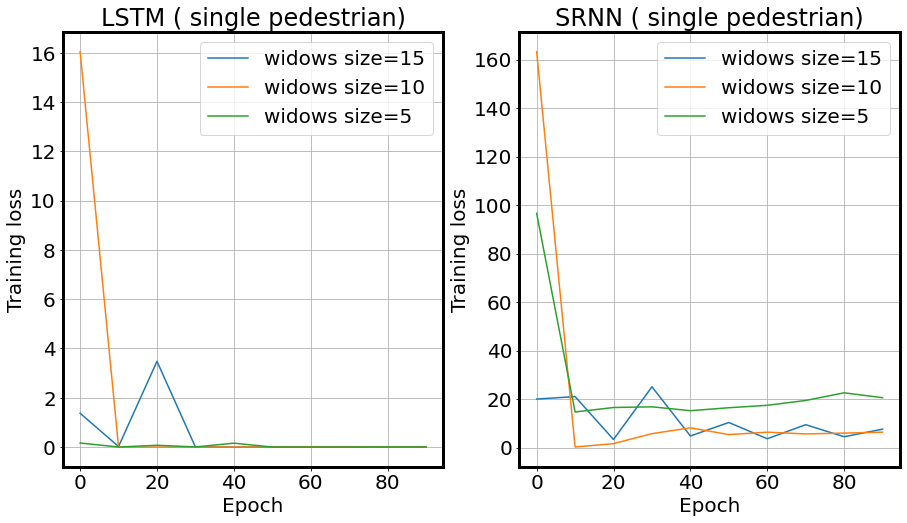

In [147]:
EPoch=np.arange(0,num_epochs,10)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax = axs[0]
ax.plot(EPoch,test_Loss_lstm_15[0:num_epochs:10],label="widows size=15")
ax.plot(EPoch,test_Loss_lstm_10[0:num_epochs:10],label="widows size=10")
ax.plot(EPoch,test_Loss_lstm_5[0:num_epochs:10],label="widows size=5")
ax.legend()
ax.grid()
ax.set_title("LSTM ( single pedestrian)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training loss")
ax = axs[1]
ax.plot(EPoch,test_Loss_srnn_15[0:num_epochs:10],label="widows size=15")
ax.plot(EPoch,test_Loss_srnn_10[0:num_epochs:10],label="widows size=10")
ax.plot(EPoch,test_Loss_srnn_5[0:num_epochs:10],label="widows size=5")
ax.legend()
ax.grid()
ax.set_title("SRNN ( single pedestrian)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training loss")
plt.rcParams['axes.linewidth'] = 3

In [148]:
def prediction(model_name, series, window_size):
    model = torch.load(model_name)
    model.eval()
    model = model.to(device)
    forcast = []
    for time_step in range(len(x_train) - window_size):
        Input_time = series_t[time_step:time_step+window_size,:,:]
        #print(Input_time)
        Input_time = Input_time.float()
        Input_time = Input_time.to(device)
        #print(model(Input_time))
        forcast.append(model(Input_time))
        #print(forcast.append(model(Input_time)))
    result = forcast[split_time-window_size:]
    result = [x.detach().cpu().numpy().squeeze() for x in result]
    return result

In [150]:
#srnn_result = prediction('SRNN_ckpt_time_series.pth', x_test, window_size)
lstm_result_x_15 = prediction('ckpt_time_series_lstm_15.pth', x_test, window_size)
lstm_result_x_10 = prediction('ckpt_time_series_lstm_10.pth', x_test, window_size)
lstm_result_x_5 = prediction('ckpt_time_series_lstm_5.pth', x_test, window_size)
srnn_result_x_15 = prediction('ckpt_time_series_srnn_15.pth', x_test, window_size)
srnn_result_x_10 = prediction('ckpt_time_series_srnn_10.pth', x_test, window_size)
srnn_result_x_5 = prediction('ckpt_time_series_lstm_5.pth', x_test, window_size)
#lstm_result

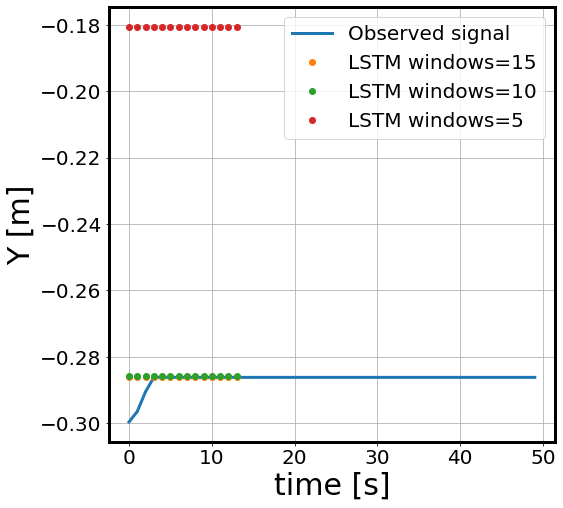

In [162]:
#plt.figure(figsize=(12, 7))
t=np.arange(len(x_train))
plt.plot(t, x_test, lw = 3)
plt.plot(t[0:len(lstm_result_x_15)],lstm_result_x_15 ,'o', lw = 3)
plt.plot(t[0:len(lstm_result_x_10)],lstm_result_x_10,'o', lw = 3)
plt.plot(t[0:len(lstm_result_x_5)],lstm_result_x_5 ,'o', lw = 3)
#plt.plot(t[0:len(srnn_result)],srnn_result ,'^', lw = 3, c = 'g')
plt.grid()
plt.legend(['Observed signal', 'LSTM windows=15', 'LSTM windows=10', 'LSTM windows=5'])
plt.xlabel('time [s]',fontsize=30)
plt.ylabel('Y [m]',fontsize=30)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams.update({'font.size': 20})

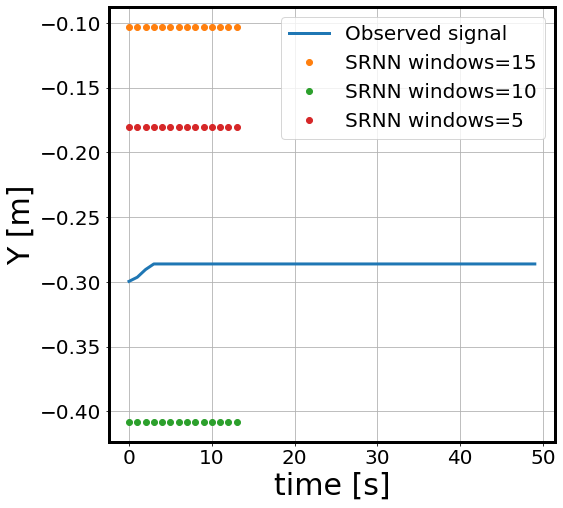

In [164]:
#plt.figure(figsize=(12, 7))
t=np.arange(len(x_train))
plt.plot(t, x_test, lw = 3)
plt.plot(t[0:len(srnn_result_x_15)],srnn_result_x_15 ,'o', lw = 3)
plt.plot(t[0:len(srnn_result_x_10)],srnn_result_x_10,'o', lw = 3)
plt.plot(t[0:len(srnn_result_x_5)],srnn_result_x_5 ,'o', lw = 3)
#plt.plot(t[0:len(srnn_result)],srnn_result ,'^', lw = 3, c = 'g')
plt.grid()
plt.legend(['Observed signal', 'SRNN windows=15', 'SRNN windows=10', 'SRNN windows=5'])
plt.xlabel('time [s]',fontsize=30)
plt.ylabel('Y [m]',fontsize=30)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams.update({'font.size': 20})

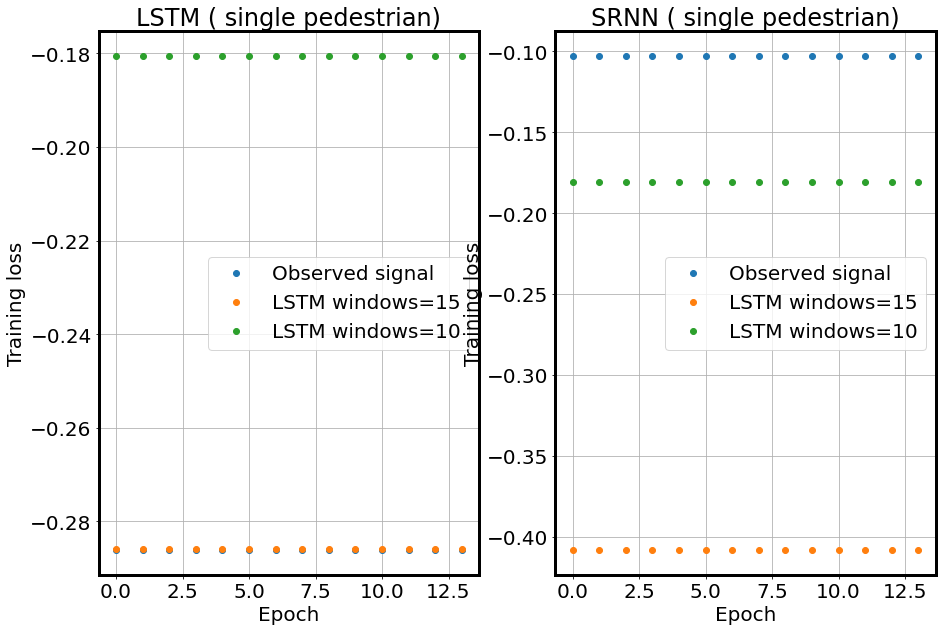

In [161]:
EPoch=np.arange(0,num_epochs,10)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax = axs[0]
ax.plot(t[0:len(lstm_result_x_15)],lstm_result_x_15 ,'o', lw = 3)
ax.plot(t[0:len(lstm_result_x_10)],lstm_result_x_10,'o', lw = 3)
ax.plot(t[0:len(lstm_result_x_5)],lstm_result_x_5 ,'o', lw = 3)
ax.legend(['Observed signal', 'LSTM windows=15', 'LSTM windows=10', 'LSTM windows=5'])
ax.grid()
ax.set_title("LSTM ( single pedestrian)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training loss")
ax = axs[1]
ax.plot(t[0:len(srnn_result_x_15)],srnn_result_x_15 ,'o', lw = 3)
ax.plot(t[0:len(srnn_result_x_10)],srnn_result_x_10,'o', lw = 3)
ax.plot(t[0:len(srnn_result_x_5)],srnn_result_x_5 ,'o', lw = 3)
ax.legend(['Observed signal', 'LSTM windows=15', 'LSTM windows=10', 'LSTM windows=5'])
ax.grid()
ax.set_title("SRNN ( single pedestrian)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training loss")
plt.rcParams['axes.linewidth'] = 3

# Multi pedsterian tracking

In [22]:
First_ped=df.T.groupby(0).get_group(374).drop([0], axis=1)

for i in range(377,388):
  First_ped=pd.concat([First_ped,df.T.groupby(0).get_group(i).drop([0], axis=1)], axis=1,ignore_index=True)
  
data_clean=First_ped.fillna(0)

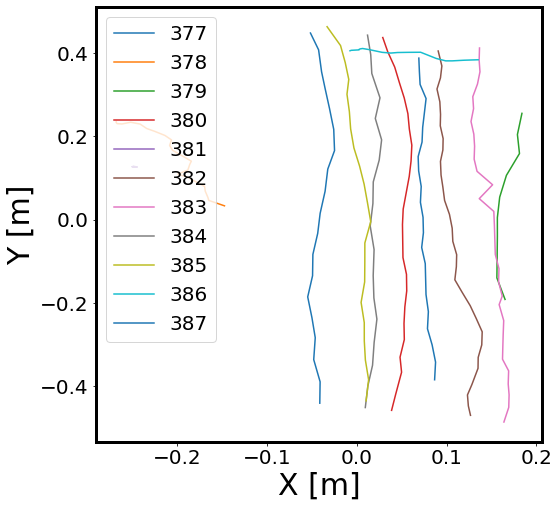

In [23]:
for i in range(377,388):
   plt.plot(df.T.groupby(0).get_group(i)[1],df.T.groupby(0).get_group(i)[2],label=str(i))
plt.xlabel('X [m]',fontsize=30)
plt.ylabel('Y [m]',fontsize=30)
plt.rcParams['axes.linewidth'] = 8
plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams.update({'font.size': 20})
plt.legend()

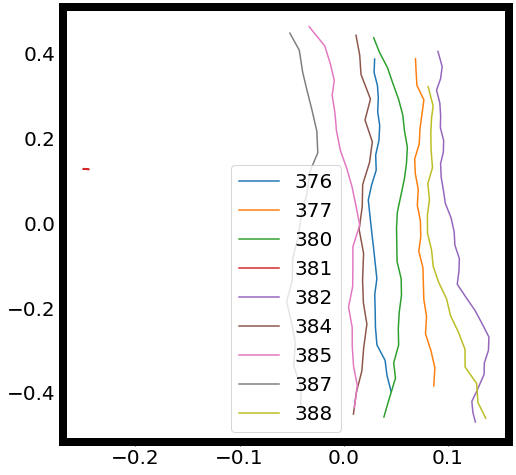

In [24]:
selected_data=[376,377,380,381,382,384,385,387,388]
for i in selected_data:
   plt.plot(df.T.groupby(0).get_group(i)[1],df.T.groupby(0).get_group(i)[2],label=str(i))
   plt.legend()

In [29]:

First_ped=df.T.groupby(0).get_group(376).drop([0], axis=1)

for i in selected_data:
  First_ped=pd.concat([First_ped,df.T.groupby(0).get_group(i).drop([0], axis=1)], axis=1,ignore_index=False)
  
data_clean=First_ped.fillna(0)
data_clean

,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2
16161.15,0.029805,0.38667,0.029805,0.38667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
16171.15,0.029284,0.35510,0.029284,0.35510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
16181.15,0.032499,0.32422,0.032499,0.32422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
16191.15,0.033345,0.29505,0.033345,0.29505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
16201.15,0.032752,0.26213,0.032752,0.26213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16641.4,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084057,0.17277
16651.4,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083778,0.21217
16661.4,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084488,0.24745
16671.4,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086045,0.27602


In [84]:
split_time = 1
window_size = 15
batch_size = 4
input_dim = 10
hidden_dim = 40
out_dim = 10
num_layers = 40
num_dir = 2
num_epochs = 100
learning_rate = 0.005
rnn_module = "srnn"  #lsdm  

In [79]:
x_train_g = data_clean.iloc[:97, :][2].to_numpy()
x_test_g = data_clean.iloc[97:194,:][2]

In [80]:
def Windowed_Dataset(series, window_size, stride, batch_size):
    """
    params:
        series: time series data
        window_size: K
        stride: stride between windows
        batch_size: batch size for training
    return:
        ds_loader: wrap windowed data into pytorch dataloader
    """
    f_s = window_size + 1
    l = len(series)
    ds = torch.from_numpy(series)
    #ds = torch.unsqueeze(ds, dim=1)
    ds = [ds[i:i+f_s] for i in range(0, l, stride) if i <= l-f_s]
    #print(ds)
    ds_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=1)
    return ds_loader
train_loader_g = Windowed_Dataset(x_train_g, window_size=window_size, stride=1, batch_size=batch_size)
test_loader_g = Windowed_Dataset(x_test_g.to_numpy(), window_size=window_size, stride=1, batch_size=batch_size)

In [81]:
train_loader_g = Windowed_Dataset(x_train_g, window_size=window_size, stride=1, batch_size=batch_size)
test_loader_g = Windowed_Dataset(x_test_g.to_numpy(), window_size=window_size, stride=1, batch_size=batch_size)

In [85]:
model = RNN(input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module)
model = model.to(device)
criterion = nn.SmoothL1Loss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

RNN(
  (rnnmodule): RNN(10, 40, num_layers=40, bidirectional=True)
  (linear): Linear(in_features=80, out_features=10, bias=True)
)


In [86]:
best_loss = 1e+100
test_Loss_srnn_15=torch.zeros(num_epochs)
train_Loss_srnn_15=torch.zeros(num_epochs)
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    running_test_loss = 0
    for batch_index, item in enumerate(train_loader_g):
        
        inputs = item[0:batch_size,0:-1]
        #print(inputs.size())
        #print(inputs)
        inputs = torch.transpose(inputs, 0, 1)
        inputs = inputs.float()
        inputs = inputs.to(device)
        #print(inputs)
        target = item[0:batch_size,-1:].squeeze(dim=1)
        target = target.float()
        target = target.to(device)
        
        optimizer.zero_grad()
        #print(inputs.size())
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()       
    with torch.no_grad():
        for batch_index, item in enumerate(test_loader_g):
            inputs_test = item[0:batch_size,0:-1]
            inputs_test = torch.transpose(inputs_test, 0, 1)
            inputs_test = inputs_test.float()
            inputs_test = inputs_test.to(device)
            target_test = item[0:batch_size,-1:].squeeze(dim=1)
            target_test = target_test.float()
            target_test = target_test.to(device)

            out_test = model(inputs_test)
            loss_test = criterion(out_test, target_test)
            running_test_loss += loss_test.item()
        if epoch%10 == 0:
            print('Epoch {} : Training loss is {:.4f} \
                '.format(epoch, running_train_loss/(batch_index+1)))
            print('Epoch {} : Test loss is {:.4f} \
                '.format(epoch, running_test_loss/(batch_index+1)))
            test_Loss_srnn_15[epoch]=running_test_loss/(batch_index+1)
            train_Loss_srnn_15[epoch]=running_train_loss/(batch_index+1)
        if best_loss > running_test_loss*batch_size/len(x_test):
            torch.save(model, 'ckpt_time_series_g.pth')
            best_loss = running_test_loss*batch_size/len(x_test)

Epoch 0 : Training loss is 79.7258                 
Epoch 0 : Test loss is 69.3934                 
Epoch 10 : Training loss is 14.3011                 
Epoch 10 : Test loss is 18.8445                 
Epoch 20 : Training loss is 10.0558                 
Epoch 20 : Test loss is 7.2875                 
Epoch 30 : Training loss is 9.9966                 
Epoch 30 : Test loss is 13.8673                 
Epoch 40 : Training loss is 6.4481                 
Epoch 40 : Test loss is 6.7941                 
Epoch 50 : Training loss is 7.4998                 
Epoch 50 : Test loss is 4.8382                 
Epoch 60 : Training loss is 3.5277                 
Epoch 60 : Test loss is 3.4493                 
Epoch 70 : Training loss is 3.0125                 
Epoch 70 : Test loss is 2.2810                 
Epoch 80 : Training loss is 2.4974                 
Epoch 80 : Test loss is 2.2146                 
Epoch 90 : Training loss is 0.5261                 
Epoch 90 : Test loss is 0.3056              

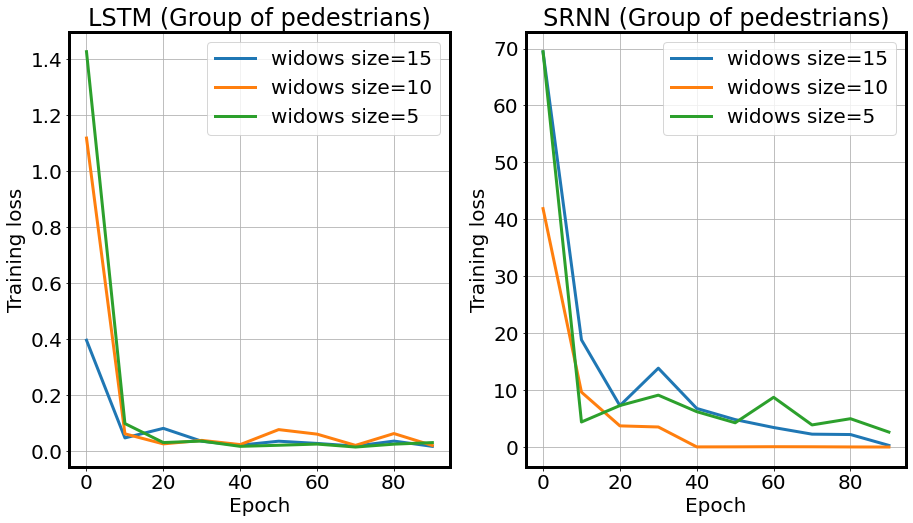

In [89]:
EPoch=np.arange(0,num_epochs,10)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax = axs[0]
ax.plot(EPoch,test_Loss_lstm_15[0:num_epochs:10],label="widows size=15",lw=3)
ax.plot(EPoch,test_Loss_lstm_10[0:num_epochs:10],label="widows size=10",lw=3)
ax.plot(EPoch,test_Loss_lstm_5[0:num_epochs:10],label="widows size=5",lw=3)
ax.legend()
ax.grid()
ax.set_title("LSTM (Group of pedestrians)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training loss")
ax = axs[1]
ax.plot(EPoch,test_Loss_srnn_15[0:num_epochs:10],label="widows size=15",lw=3)
ax.plot(EPoch,test_Loss_srnn_10[0:num_epochs:10],label="widows size=10",lw=3)
ax.plot(EPoch,test_Loss_srnn_5[0:num_epochs:10],label="widows size=5",lw=3)
ax.legend()
ax.grid()
ax.set_title("SRNN (Group of pedestrians)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training loss")
plt.rcParams['axes.linewidth'] = 3

In [29]:
def prediction(model_name, series, window_size):
    model = torch.load(model_name)
    model.eval()
    model = model.to(device)
    forcast = []
    for time_step in range(len(series) - window_size):
        Input_time = series_t[time_step:time_step+window_size,:,:]
        #print(Input_time)
        Input_time = Input_time.float()
        Input_time = Input_time.to(device)
        #print(model(Input_time))
        forcast.append(model(Input_time))
        #print(forcast.append(model(Input_time)))
    result = forcast[split_time-window_size:]
    result = [x.detach().cpu().numpy().squeeze() for x in result]
    return result

In [1]:
train_loader

NameError: ignored

In [83]:
x_test_g

,2,2,2,2,2,2,2,2,2,2
16411.5,0.0,0.0,0.0,0.0,0.0,-0.112750,0.0,0.0,0.0,0.00000
16421.5,0.0,0.0,0.0,0.0,0.0,-0.083901,0.0,0.0,0.0,0.00000
16431.5,0.0,0.0,0.0,0.0,0.0,-0.051937,0.0,0.0,0.0,0.00000
16441.5,0.0,0.0,0.0,0.0,0.0,-0.020360,0.0,0.0,0.0,0.00000
16451.5,0.0,0.0,0.0,0.0,0.0,0.012797,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...
16641.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.17277
16651.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.21217
16661.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.24745
16671.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.27602


# Two dimentional RNN

In [22]:
y_train = df.T.groupby(0).get_group(38).drop([0], axis=1).iloc[:50, :][1].to_numpy()
y_test = df.T.groupby(0).get_group(38).drop([0], axis=1).iloc[50:100,:][1]


In [23]:
def Windowed_Dataset(series, window_size, stride, batch_size):
    """
    params:
        series: time series data
        window_size: K
        stride: stride between windows
        batch_size: batch size for training
    return:
        ds_loader: wrap windowed data into pytorch dataloader
    """
    f_s = window_size + 1
    l = len(series)
    ds = torch.from_numpy(series)
    ds = torch.unsqueeze(ds, dim=1)
    ds = [ds[i:i+f_s] for i in range(0, l, stride) if i <= l-f_s]
    #print(ds)
    ds_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=1)
    return ds_loader
train_loader = Windowed_Dataset(y_train, window_size=window_size, stride=1, batch_size=batch_size)
test_loader = Windowed_Dataset(y_test.to_numpy(), window_size=window_size, stride=1, batch_size=batch_size)

In [24]:
class RNN2D(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module):
        super(RNN2D, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.out_dim = out_dim 
        self.bs = batch_size
        self.nd = num_dir
        
        if self.nd == 2:
            bidir = True
        else:
            bidir = False
        if rnn_module == "srnn":
            self.rnnmodule = nn.RNN(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidir)
        elif rnn_module == "lstm":
            self.rnnmodule = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidir)
        self.linearx = nn.Linear(self.hidden_dim*self.nd, self.out_dim)
        self.lineary = nn.Linear(self.hidden_dim*self.nd, self.out_dim)
    
    def forward(self, x):
#         h0 = torch.zeros(self.num_layers, self.bs, self.hidden_dim).to(device)
        #print("hi1")
        #hidden = self._init_hidden(batch_size)

        out, _ = self.rnnmodule(x)
        
        outx = self.linearx(out[-1])
        outy= self.lineary(out[-1])
        outx = outx*1000
        out = out*1000
        return outx,outy

In [25]:
split_time = 2
window_size = 10
batch_size = 5
input_dim = 1
hidden_dim = 10
out_dim = 1
num_layers = 5
num_dir = 2
num_epochs = 100
learning_rate = 0.0001
rnn_module = "lstm"  #lsdm 

In [26]:
model = RNN(input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module)
model = model.to(device)
criterion = nn.SmoothL1Loss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

RNN(
  (rnnmodule): LSTM(1, 10, num_layers=5, bidirectional=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
)


In [27]:
best_loss = 1e+100
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    running_test_loss = 0
    for batch_index, item in enumerate(train_loader):
        
        inputs = item[0:batch_size,0:-1]
        #print(inputs.size())
        #print(inputs)
        inputs = torch.transpose(inputs, 0, 1)
        inputs = inputs.float()
        inputs = inputs.to(device)
        #print(inputs)
        target = item[0:batch_size,-1:].squeeze(dim=1)
        target = target.float()
        target = target.to(device)
        
        optimizer.zero_grad()
        #print(inputs.size())
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()       
    with torch.no_grad():
        for batch_index, item in enumerate(test_loader):
            inputs_test = item[0:batch_size,0:-1]
            inputs_test = torch.transpose(inputs_test, 0, 1)
            inputs_test = inputs_test.float()
            inputs_test = inputs_test.to(device)
            target_test = item[0:batch_size,-1:].squeeze(dim=1)
            target_test = target_test.float()
            target_test = target_test.to(device)

            out_test = model(inputs_test)
            loss_test = criterion(out_test, target_test)
            running_test_loss += loss_test.item()
        if epoch%10 == 0:
            print('Epoch {} : Training loss is {:.4f} \
                '.format(epoch, running_train_loss/(batch_index+1)))
            print('Epoch {} : Test loss is {:.4f} \
                '.format(epoch, running_test_loss/(batch_index+1)))
        if best_loss > running_test_loss*batch_size/len(x_test):
            torch.save(model, 'ckpt_time_series_g.pth')
            best_loss = running_test_loss*batch_size/len(x_test)

Epoch 0 : Training loss is 23.2096                 
Epoch 0 : Test loss is 22.6483                 
Epoch 10 : Training loss is 11.4718                 
Epoch 10 : Test loss is 10.6845                 
Epoch 20 : Training loss is 0.0126                 
Epoch 20 : Test loss is 0.0000                 
Epoch 30 : Training loss is 0.0000                 
Epoch 30 : Test loss is 0.0001                 
Epoch 40 : Training loss is 0.0000                 
Epoch 40 : Test loss is 0.0001                 
Epoch 50 : Training loss is 0.0000                 
Epoch 50 : Test loss is 0.0001                 
Epoch 60 : Training loss is 0.0000                 
Epoch 60 : Test loss is 0.0001                 
Epoch 70 : Training loss is 0.0000                 
Epoch 70 : Test loss is 0.0001                 
Epoch 80 : Training loss is 0.0000                 
Epoch 80 : Test loss is 0.0001                 
Epoch 90 : Training loss is 0.0000                 
Epoch 90 : Test loss is 0.0001                

In [30]:
#srnn_result = prediction('SRNN_ckpt_time_series.pth', x_test, window_size)
lstm_result_y = prediction('ckpt_time_series_g.pth', y_test, window_size)
#lstm_result

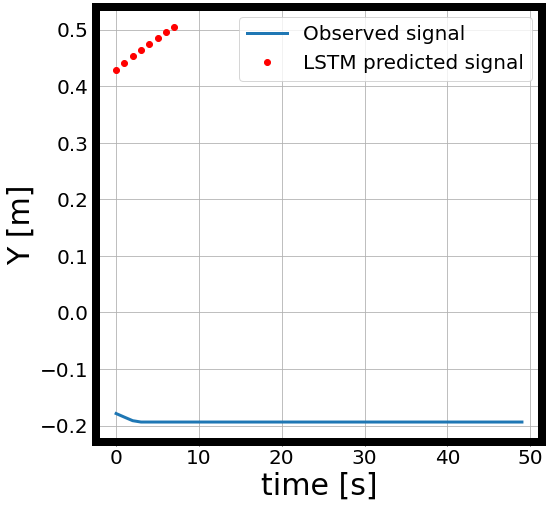

In [31]:
#plt.figure(figsize=(12, 7))
t=np.arange(len(y_train))
plt.plot(t, y_test, lw = 3)
plt.plot(t[0:len(lstm_result_y)],lstm_result_y ,'o', lw = 3, c = 'r')
#plt.plot(t[0:len(srnn_result)],srnn_result ,'^', lw = 3, c = 'g')
plt.grid()
plt.legend(['Observed signal', 'LSTM predicted signal','SRNN predicted signal'])
plt.xlabel('time [s]',fontsize=30)
plt.ylabel('Y [m]',fontsize=30)
plt.rcParams['axes.linewidth'] = 8
plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams.update({'font.size': 20})

In [32]:
#plt.figure(figsize=(12, 7))
t=np.arange(len(y_train))
#plt.plot(x_test, y_test, lw = 3)
plt.plot(lstm_result_x,lstm_result_y ,'o', lw = 3, c = 'r')
#plt.plot(t[0:len(srnn_result)],srnn_result ,'^', lw = 3, c = 'g')
plt.grid()
plt.legend(['Observed signal', 'LSTM predicted signal','SRNN predicted signal'])
plt.xlabel('time [s]',fontsize=30)
plt.ylabel('Y [m]',fontsize=30)
plt.rcParams['axes.linewidth'] = 8
plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams.update({'font.size': 20})

NameError: ignored

# data for crowds

In [90]:
sampl11=df.T.groupby(0).get_group(1).drop([0], axis=1)

for i in df.T.groupby(0).groups.keys():
  sampl11=pd.concat([sampl11,df.T.groupby(0).get_group(i).drop([0], axis=1)], axis=1,ignore_index=False)

data_clean=sampl11.fillna(0)


,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,...,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2
1,0.000537,-0.18457,0.000537,-0.18457,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
11,-0.008186,-0.22938,-0.008186,-0.22938,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
1.1,0.000000,0.00000,0.000000,0.00000,-0.058169,-0.26861,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
11.1,0.000000,0.00000,0.000000,0.00000,-0.055556,-0.31207,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
1.2,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.057966,-0.10479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18021.3,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14191,-0.33849
18031.3,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14649,-0.29685
18041.3,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14752,-0.25501
18051.3,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14847,-0.21453


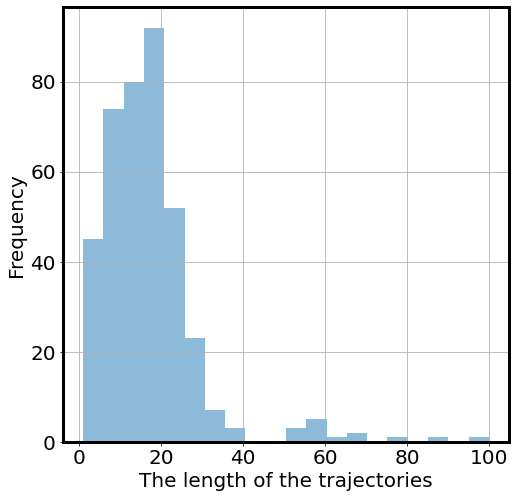

In [119]:
a=df.T.groupby(0).size()
a.plot.hist(bins=20, alpha=0.5)
plt.xlabel("The length of the trajectories")
plt.grid()

In [99]:
split_time = 1
window_size = 15
batch_size = 4
input_dim = 391
hidden_dim = 40
out_dim = 391
num_layers = 40
num_dir = 2
num_epochs = 100
learning_rate = 0.005
rnn_module = "srnn"  #lsdm  

In [93]:
x_train_c = data_clean.iloc[:3272, :][2].to_numpy()
x_test_c = data_clean.iloc[3272:6544,:][2]

In [94]:
def Windowed_Dataset(series, window_size, stride, batch_size):
    """
    params:
        series: time series data
        window_size: K
        stride: stride between windows
        batch_size: batch size for training
    return:
        ds_loader: wrap windowed data into pytorch dataloader
    """
    f_s = window_size + 1
    l = len(series)
    ds = torch.from_numpy(series)
    #ds = torch.unsqueeze(ds, dim=1)
    ds = [ds[i:i+f_s] for i in range(0, l, stride) if i <= l-f_s]
    #print(ds)
    ds_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=1)
    return ds_loader
train_loader_c = Windowed_Dataset(x_train_c, window_size=window_size, stride=1, batch_size=batch_size)
test_loader_c = Windowed_Dataset(x_test_c.to_numpy(), window_size=window_size, stride=1, batch_size=batch_size)

In [100]:
model = RNN(input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module)
model = model.to(device)
criterion = nn.SmoothL1Loss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

RNN(
  (rnnmodule): RNN(391, 40, num_layers=40, bidirectional=True)
  (linear): Linear(in_features=80, out_features=391, bias=True)
)


In [101]:
best_loss = 1e+100
test_Loss_srnn_15=torch.zeros(num_epochs)
train_Loss_srnn_15=torch.zeros(num_epochs)
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    running_test_loss = 0
    for batch_index, item in enumerate(train_loader_c):
        
        inputs = item[0:batch_size,0:-1]
        #print(inputs.size())
        #print(inputs)
        inputs = torch.transpose(inputs, 0, 1)
        inputs = inputs.float()
        inputs = inputs.to(device)
        #print(inputs)
        target = item[0:batch_size,-1:].squeeze(dim=1)
        target = target.float()
        target = target.to(device)
        
        optimizer.zero_grad()
        #print(inputs.size())
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()       
    with torch.no_grad():
        for batch_index, item in enumerate(test_loader_c):
            inputs_test = item[0:batch_size,0:-1]
            inputs_test = torch.transpose(inputs_test, 0, 1)
            inputs_test = inputs_test.float()
            inputs_test = inputs_test.to(device)
            target_test = item[0:batch_size,-1:].squeeze(dim=1)
            target_test = target_test.float()
            target_test = target_test.to(device)

            out_test = model(inputs_test)
            loss_test = criterion(out_test, target_test)
            running_test_loss += loss_test.item()
        if epoch%10 == 0:
            print('Epoch {} : Training loss is {:.4f} \
                '.format(epoch, running_train_loss/(batch_index+1)))
            print('Epoch {} : Test loss is {:.4f} \
                '.format(epoch, running_test_loss/(batch_index+1)))
            test_Loss_srnn_15[epoch]=running_test_loss/(batch_index+1)
            train_Loss_srnn_15[epoch]=running_train_loss/(batch_index+1)
        if best_loss > running_test_loss*batch_size/len(x_test):
            torch.save(model, 'ckpt_time_series_g.pth')
            best_loss = running_test_loss*batch_size/len(x_test)

Epoch 0 : Training loss is 2.1471                 
Epoch 0 : Test loss is 0.0029                 


KeyboardInterrupt: ignored